# Label side

In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-31"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2846880, 6)

In [2]:
np.save("data/btc_1m.npy", candles)

In [3]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2846880, 6)

In [4]:
from scipy import stats
from custom_indicators.toolbox.bar.fusion.v1 import FusionBarContainerV1

bar_container = FusionBarContainerV1()
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

4.661732959995715

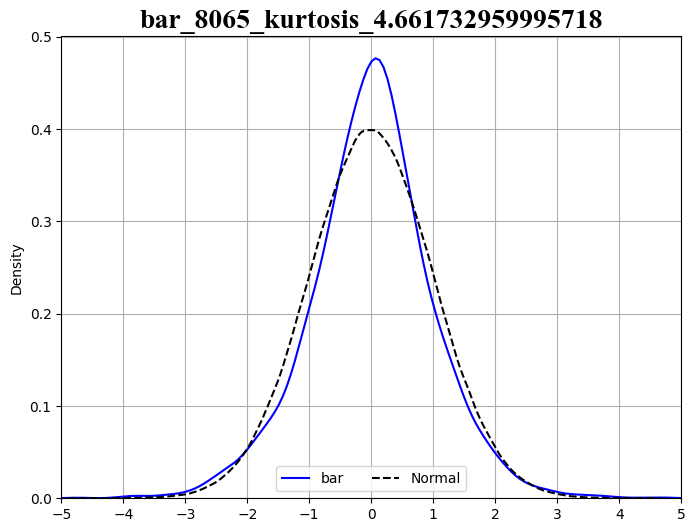

In [5]:
from custom_indicators.utils.plot import plot_kde

L = 1

plot_kde(merged_bar[:, 2], lag=L)

In [23]:
from hmmlearn.hmm import GMMHMM
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from jesse.helpers import timestamp_to_time

mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

X = np.column_stack([HL_diff, log_return_L, log_return])

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=3,
    n_mix=mix,
    covariance_type="diag",
    n_iter=1000,
    random_state=42,
    # weights_prior=2,
    means_weight=0.5,
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)

print(np.unique(latent_states_sequence, return_counts=True))

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i in range(gmm.n_components):
    state = latent_states_sequence == i
    fig.add_trace(
        go.Scatter(
            x=datelist[state],
            y=closeidx[state],
            mode="markers",
            name=f"latent state {i}",
            marker=dict(color=colors[i % len(colors)], size=4),
        )
    )

fig.update_layout(
    title="隐含状态序列",
    xaxis_title="时间",
    yaxis_title="收盘价",
    # width=1400,
    # height=600,
    showlegend=True,
)

fig.show()

(array([0, 1, 2]), array([2055, 2175, 3840]))


state 1 (2175) return: 1650.779564%
state 2 (3840) return: -0.468860%
state 0 (2055) return: -1378.316265%


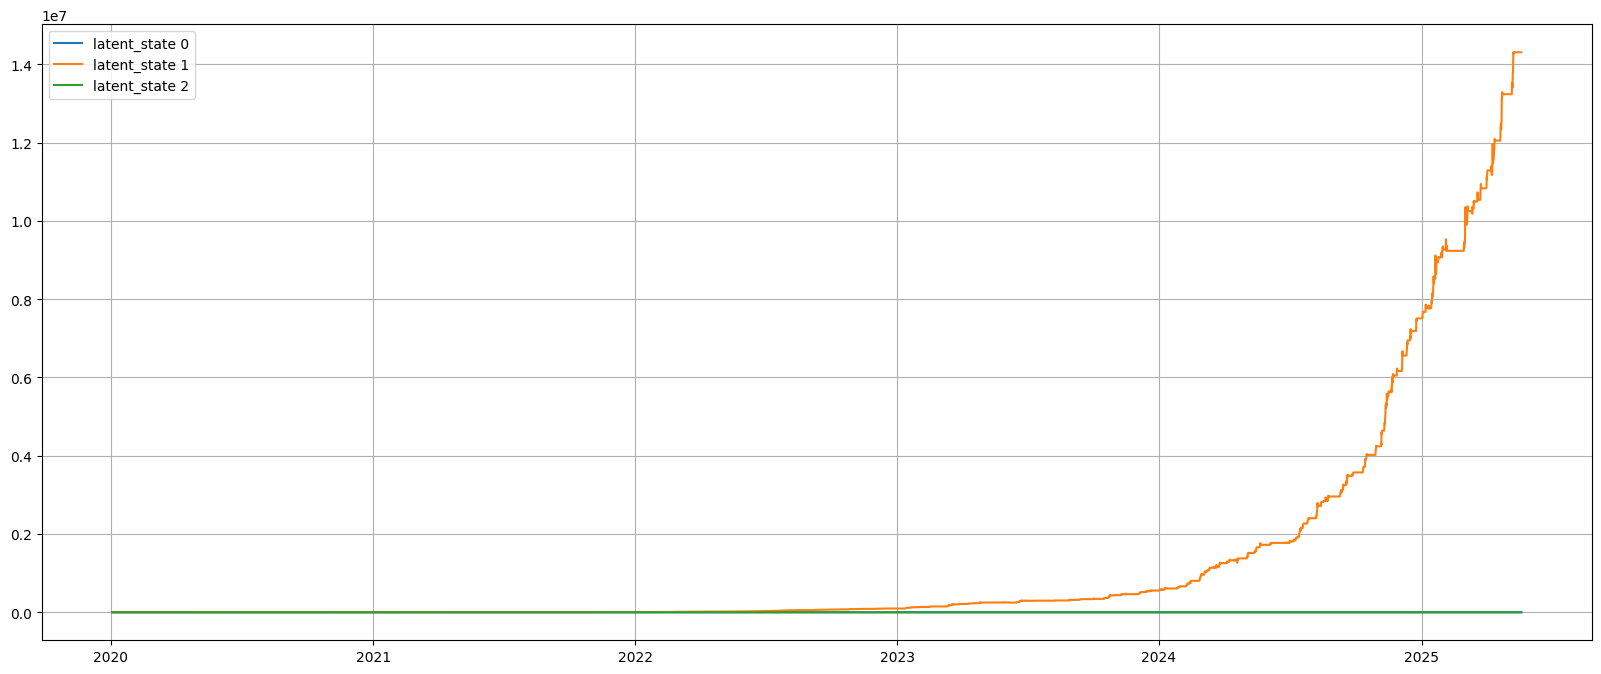

In [24]:
import matplotlib.pyplot as plt

data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": log_return,
        "state": latent_states_sequence,
    }
).set_index("datelist")

for i in data["state"].unique():
    ret = data[data["state"] == i]["logreturn"].sum()
    count = data[data["state"] == i].shape[0]
    print(f"state {i} ({count}) return: {ret:.6%}")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

In [25]:
assert len(merged_bar[L:]) == len(latent_states_sequence)

In [29]:
# 保存merged bar, 去除最后一个bar，因为需要label前移一位
print(merged_bar[:-1].shape)
np.save("data/merged_bar.npy", merged_bar[:-1])

(8074, 6)


In [28]:
label_long = (latent_states_sequence == 1).astype(int)
print(np.unique(label_long, return_counts=True))
np.save("data/side_label_long.npy", label_long)

label_short = (latent_states_sequence == 0).astype(int)
print(np.unique(label_short, return_counts=True))
np.save("data/side_label_short.npy", label_short)


(array([0, 1]), array([5895, 2175]))
(array([0, 1]), array([6015, 2055]))


# Label meta

In [3]:
import numpy as np
import pandas as pd

df_features = pd.read_parquet("data/features.parquet")
label_long = np.load("data/side_label_long.npy")
label_short = np.load("data/side_label_short.npy")

print(df_features.shape)
print(label_long.shape)
print(label_short.shape)

len_gap = len(label_long) - len(df_features)
print(f"{len_gap = }")

label_long = label_long[len_gap:]
label_short = label_short[len_gap:]

print(label_long.shape)
print(label_short.shape)


(8006, 3447)
(8070,)
(8070,)
len_gap = 64
(8006,)
(8006,)


In [7]:
import lightgbm as lgb

from strategies.BinanceBtcEntropyBarV1.config import SIDE_LONG, SIDE_SHORT

model_long = lgb.Booster(
    model_file="strategies/BinanceBtcEntropyBarV1/model/model_side_long.txt"
)
model_short = lgb.Booster(
    model_file="strategies/BinanceBtcEntropyBarV1/model/model_side_short.txt"
)

res_long = model_long.predict(df_features[SIDE_LONG])
res_short = model_short.predict(df_features[SIDE_SHORT])

label_long_pred = np.where(res_long > 0.5, 1, 0)
label_short_pred = np.where(res_short > 0.5, 1, 0)

print(np.unique(label_long_pred, return_counts=True))
print(np.unique(label_short_pred, return_counts=True))


(array([0, 1]), array([5860, 2146]))
(array([0, 1]), array([5954, 2052]))


In [11]:
should_long = (label_long_pred == 1) & (label_short_pred == 0) & (label_long == 1)
print(np.unique(should_long, return_counts=True))

should_short = (label_short_pred == 1) & (label_long_pred == 0) & (label_short == 1)
print(np.unique(should_short, return_counts=True))


(array([False,  True]), array([5899, 2107]))
(array([False,  True]), array([5996, 2010]))


In [13]:
meta_label = (should_long | should_short).astype(int)
print(f"{meta_label.shape = }")
print(np.unique(meta_label, return_counts=True))

meta_label.shape = (8006,)
(array([0, 1]), array([3889, 4117]))


In [14]:
np.save("data/label_meta.npy", meta_label)